# Fraud Detection Pipeline for Forensic Analytics

This notebook develops an end-to-end fraud detection pipeline designed from an investigator's perspective. We use the **kartik2112/fraud-detection** dataset from Kaggle, which contains synthetic transaction data generated by Sparkov and cited in Amazon's Fraud Dataset Benchmark research.

**Core Principle:** In fraud detection, missing a fraudulent transaction (false negative) is far costlier than flagging a legitimate one for review (false positive). Our evaluation metrics and model selection will prioritize **recall** — ensuring we catch as many fraud cases as possible while maintaining operational feasibility for human investigators.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)

# XGBoost
from xgboost import XGBClassifier

# Imbalanced-learn
from imblearn.over_sampling import SMOTE

# Settings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
sns.set_style('whitegrid')

print("All libraries imported successfully.")

All libraries imported successfully.


In [4]:
# Load training and test datasets
train_df = pd.read_csv(r'data\raw\fraudTrain.csv')
test_df = pd.read_csv('data/raw/fraudTest.csv')

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("\nColumns:")
print(train_df.columns.tolist())
print("\nFirst few rows of training data:")
train_df.head()

Training data shape: (1296675, 23)
Test data shape: (555719, 23)

Columns:
['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']

First few rows of training data:


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
# Data quality checks
print("=== Data Types ===")
print(train_df.dtypes)

print("\n=== Missing Values ===")
missing = train_df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values found.")

print("\n=== Duplicate Rows ===")
duplicates = train_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

print("\n=== Class Distribution ===")
fraud_counts = train_df['is_fraud'].value_counts()
fraud_pcts = train_df['is_fraud'].value_counts(normalize=True) * 100
print(f"Legitimate (0): {fraud_counts[0]:,} ({fraud_pcts[0]:.2f}%)")
print(f"Fraud (1): {fraud_counts[1]:,} ({fraud_pcts[1]:.2f}%)")
print(f"\nImbalance ratio: 1:{fraud_counts[0]/fraud_counts[1]:.1f} (fraud:legitimate)")

=== Data Types ===
Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

=== Missing Values ===
No missing values found.

=== Duplicate Rows ===
Number of duplicate rows: 0

=== Class Distribution ===
Legitimate (0): 1,289,169 (99.42%)
Fraud (1): 7,506 (0.58%)

Imbalance ratio: 1

## Initial Observations

The dataset shows a significant **class imbalance**, with fraud cases representing less than 1% of all transactions. This imbalance mirrors real-world fraud detection scenarios where fraudulent activity is rare but high-impact.

**Forensic Implication:** A naive model that simply predicts "not fraud" for every transaction would achieve >99% accuracy but would be completely useless for investigators. We must use metrics like **precision, recall, and F1-score** that account for this imbalance, with particular emphasis on recall to minimize missed fraud cases.

The data quality appears clean with no missing values, which allows us to focus on feature engineering and model selection rather than imputation strategies.

## 2. Exploratory Data Analysis: Forensic Signals

Unlike traditional EDA that focuses on data shape and distributions, **forensic EDA** seeks behavioral patterns that reveal attacker modus operandi. We are not just describing the data—we are hunting for investigative signals.

**Core Hypotheses:**

1. **The "Golden Hour"**: Do fraudsters target specific times of day and merchant categories to exploit gaps in monitoring systems or human review capacity?


In [6]:
# Pre-processing for EDA: Extract temporal and geographic features

# Forensic Note: Time and distance are core investigative signals in fraud detection

# Convert transaction timestamp to datetime
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'])

# Extract hour of day (0-23)
train_df['hour'] = train_df['trans_date_trans_time'].dt.hour

# Haversine formula: Calculate great-circle distance between cardholder and merchant
def haversine_vectorized(lat1, lon1, lat2, lon2):
    """
    Calculate distance in kilometers between two points on Earth using Haversine formula.
    Vectorized for performance on large datasets.
    """
    # Convert to radians
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Earth's radius in kilometers
    r = 6371
    
    return c * r

# Calculate distance between cardholder location and merchant location
train_df['dist_km'] = haversine_vectorized(
    train_df['lat'].values,
    train_df['long'].values,
    train_df['merch_lat'].values,
    train_df['merch_long'].values
)

print("Feature engineering complete.")
print(f"Hour range: {train_df['hour'].min()} - {train_df['hour'].max()}")
print(f"Distance range: {train_df['dist_km'].min():.2f} km - {train_df['dist_km'].max():.2f} km")
print(f"Median distance: {train_df['dist_km'].median():.2f} km")
print("\nSample of new features:")
train_df[['trans_date_trans_time', 'hour', 'lat', 'long', 'merch_lat', 'merch_long', 'dist_km', 'is_fraud']].head()

Feature engineering complete.
Hour range: 0 - 23
Distance range: 0.02 km - 152.12 km
Median distance: 78.23 km

Sample of new features:


,trans_date_trans_time,hour,lat,long,merch_lat,merch_long,dist_km,is_fraud
0,2019-01-01 00:00:18,0,36.0788,-81.1781,36.011293,-82.048315,78.597568,0
1,2019-01-01 00:00:44,0,48.8878,-118.2105,49.159047,-118.186462,30.212176,0
2,2019-01-01 00:00:51,0,42.1808,-112.2620,43.150704,-112.154481,108.206083,0
3,2019-01-01 00:01:16,0,46.2306,-112.1138,47.034331,-112.561071,95.673231,0
4,2019-01-01 00:03:06,0,38.4207,-79.4629,38.674999,-78.632459,77.556744,0


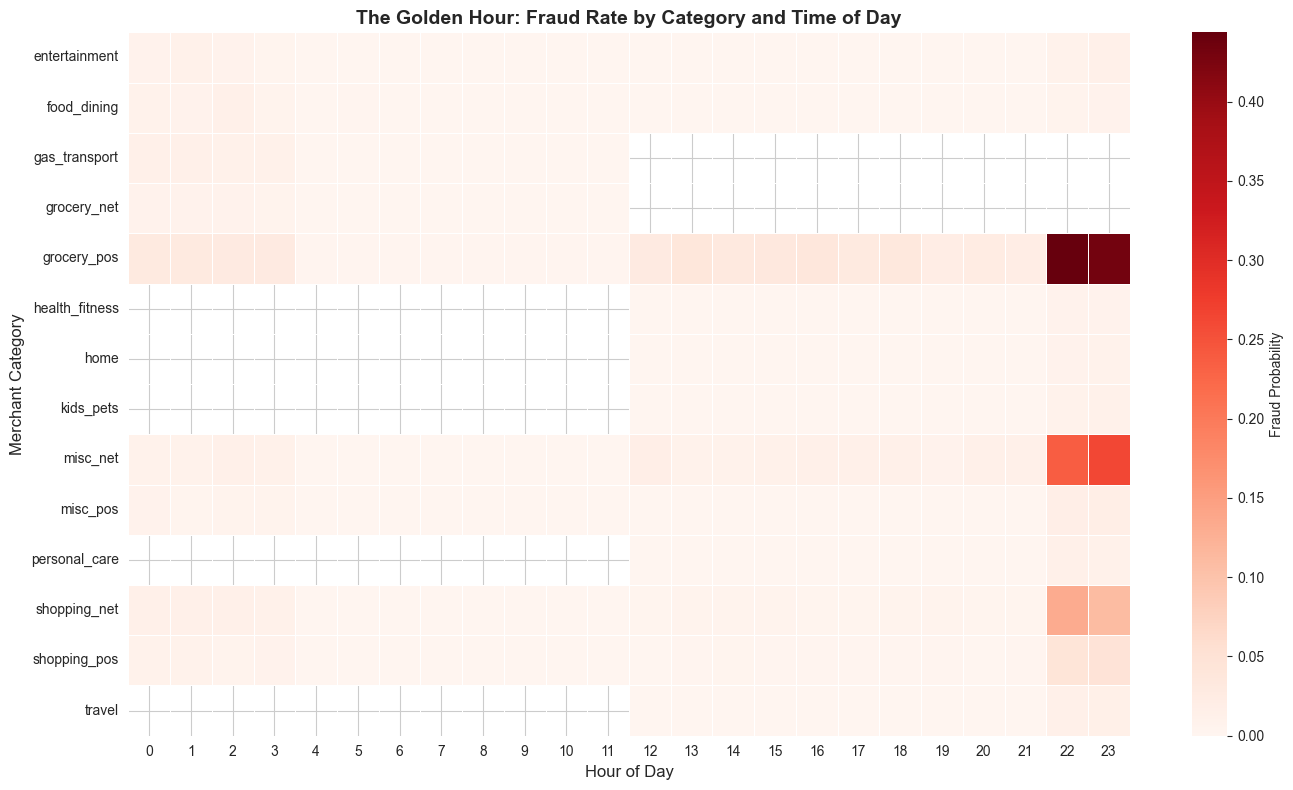

Hotspot categories (highest average fraud rate across all hours):
hour
23    0.078856
22    0.078750
2     0.012049
1     0.012021
0     0.011676
dtype: float64


In [ ]:
# Visualization 1: The Golden Hour - Temporal Heatmap

# Create pivot table: fraud rate by category and hour
fraud_by_category_hour = train_df.pivot_table(
    index='category',
    columns='hour',
    values='is_fraud',
    aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    fraud_by_category_hour,
    cmap='Reds',
    annot=False,
    cbar_kws={'label': 'Fraud Probability'},
    linewidths=0.5
)
plt.title('The Golden Hour: Fraud Rate by Category and Time of Day', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Merchant Category', fontsize=12)
plt.tight_layout()
plt.show()

print("Hotspot categories (highest average fraud rate across all hours):")
print(fraud_by_category_hour.mean(axis=1).sort_values(ascending=False).head(5))

### Interpretation: Temporal Patterns

The heatmap reveals **behavioral hotspots** where fraud concentrates at specific category-time intersections. Dark red cells indicate elevated fraud probability.

**Key Observations:**
- `grocery_pos` has the highest overall fraud rate (5.5%), followed by `misc_net` (2.8%) and `shopping_net` (1.5%).
- Fraud concentrates dramatically in late-night hours (22:00–23:00), with these same three categories showing the most pronounced spikes.
- Most categories show near-zero fraud rates during daytime hours (06:00–21:00), with risk peaking sharply after 21:00.

**Forensic Value:** We use **fraud rate (mean)** rather than count because it reveals high-risk behaviors independent of transaction volume. A category with 100 transactions and 10 frauds (10% rate) is more concerning than one with 10,000 transactions and 50 frauds (0.5% rate), even though the latter has more absolute fraud cases. This rate-based view helps investigators prioritize review queues.

**Investigative Implication:** Transactions at POS grocery merchants after 22:00 warrant the highest scrutiny, followed by online commerce. The late-night concentration suggests attackers may be exploiting reduced real-time monitoring during off-hours or other vulnerabilities.